In [1]:
import requests
# Pandas is a software library written for the Python programming language for data manipulation and analysis.
import pandas as pd
# NumPy is a library for the Python programming language, adding support for large, multi-dimensional arrays and matrices, along with a large collection of high-level mathematical functions to operate on these arrays
import numpy as np
# Datetime is a library that allows us to represent dates
import datetime

# Setting this option will print all collumns of a dataframe
pd.set_option('display.max_columns', None)
# Setting this option will print all of the data in a feature
pd.set_option('display.max_colwidth', None)

In [2]:
spacex_url="https://api.spacexdata.com/v4/launches/past"

response = requests.get(spacex_url)
print(response)

<Response [200]>


In [3]:
response = requests.get(spacex_url)
data = response.json()
data = pd.json_normalize(data)
data.head()

,static_fire_date_utc,static_fire_date_unix,net,window,rocket,success,failures,details,crew,ships,capsules,payloads,launchpad,flight_number,name,date_utc,date_unix,date_local,date_precision,upcoming,cores,auto_update,tbd,launch_library_id,id,fairings.reused,fairings.recovery_attempt,fairings.recovered,fairings.ships,links.patch.small,links.patch.large,links.reddit.campaign,links.reddit.launch,links.reddit.media,links.reddit.recovery,links.flickr.small,links.flickr.original,links.presskit,links.webcast,links.youtube_id,links.article,links.wikipedia,fairings
0,2006-03-17T00:00:00.000Z,1.142554e+09,False,0.0,5e9d0d95eda69955f709d1eb,False,"[{'time': 33, 'altitude': None, 'reason': 'merlin engine failure'}]",Engine failure at 33 seconds and loss of vehicle,[],[],[],[5eb0e4b5b6c3bb0006eeb1e1],5e9e4502f5090995de566f86,1,FalconSat,2006-03-24T22:30:00.000Z,1143239400,2006-03-25T10:30:00+12:00,hour,False,"[{'core': '5e9e289df35918033d3b2623', 'flight': 1, 'gridfins': False, 'legs': False, 'reused': False, 'landing_attempt': False, 'landing_success': None, 'landing_type': None, 'landpad': None}]",True,False,None,5eb87cd9ffd86e000604b32a,False,False,False,[],https://images2.imgbox.com/94/f2/NN6Ph45r_o.png,https://images2.imgbox.com/5b/02/QcxHUb5V_o.png,None,None,None,None,[],[],None,https://www.youtube.com/watch?v=0a_00nJ_Y88,0a_00nJ_Y88,https://www.space.com/2196-spacex-inaugural-falcon-1-rocket-lost-launch.html,https://en.wikipedia.org/wiki/DemoSat,NaN
1,None,NaN,False,0.0,5e9d0d95eda69955f709d1eb,False,"[{'time': 301, 'altitude': 289, 'reason': 'harmonic oscillation leading to premature engine shutdown'}]","Successful first stage burn and transition to second stage, maximum altitude 289 km, Premature engine shutdown at T+7 min 30 s, Failed to reach orbit, Failed to recover first stage",[],[],[],[5eb0e4b6b6c3bb0006eeb1e2],5e9e4502f5090995de566f86,2,DemoSat,2007-03-21T01:10:00.000Z,1174439400,2007-03-21T13:10:00+12:00,hour,False,"[{'core': '5e9e289ef35918416a3b2624', 'flight': 1, 'gridfins': False, 'legs': False, 'reused': False, 'landing_attempt': False, 'landing_success': None, 'landing_type': None, 'landpad': None}]",True,False,None,5eb87cdaffd86e000604b32b,False,False,False,[],https://images2.imgbox.com/f9/4a/ZboXReNb_o.png,https://images2.imgbox.com/80/a2/bkWotCIS_o.png,None,None,None,None,[],[],None,https://www.youtube.com/watch?v=Lk4zQ2wP-Nc,Lk4zQ2wP-Nc,https://www.space.com/3590-spacex-falcon-1-rocket-fails-reach-orbit.html,https://en.wikipedia.org/wiki/DemoSat,NaN
2,None,NaN,False,0.0,5e9d0d95eda69955f709d1eb,False,"[{'time': 140, 'altitude': 35, 'reason': 'residual stage-1 thrust led to collision between stage 1 and stage 2'}]",Residual stage 1 thrust led to collision between stage 1 and stage 2,[],[],[],"[5eb0e4b6b6c3bb0006eeb1e3, 5eb0e4b6b6c3bb0006eeb1e4]",5e9e4502f5090995de566f86,3,Trailblazer,2008-08-03T03:34:00.000Z,1217734440,2008-08-03T15:34:00+12:00,hour,False,"[{'core': '5e9e289ef3591814873b2625', 'flight': 1, 'gridfins': False, 'legs': False, 'reused': False, 'landing_attempt': False, 'landing_success': None, 'landing_type': None, 'landpad': None}]",True,False,None,5eb87cdbffd86e000604b32c,False,False,False,[],https://images2.imgbox.com/6c/cb/na1tzhHs_o.png,https://images2.imgbox.com/4a/80/k1oAkY0k_o.png,None,None,None,None,[],[],None,https://www.youtube.com/watch?v=v0w9p3U8860,v0w9p3U8860,http://www.spacex.com/news/2013/02/11/falcon-1-flight-3-mission-summary,https://en.wikipedia.org/wiki/Trailblazer_(satellite),NaN
3,2008-09-20T00:00:00.000Z,1.221869e+09,False,0.0,5e9d0d95eda69955f709d1eb,True,[],"Ratsat was carried to orbit on the first successful orbital launch of any privately funded and developed, liquid-propelled carrier rocket, the SpaceX Falcon 1",[],[],[],[5eb0e4b7b6c3bb0006eeb1e5],5e9e4502f5090995de566f86,4,RatSat,2008-09-28T23:15:00.000Z,1222643700,2008-09-28T11:15:00+12:00,hour,False,"[{'core': '5e9e289ef3591855dc3b2626', 'flight': 1, 'gridfins': False, 'legs': False, 'reused': False, 'landing_attempt': 

# Data Scraping

You will notice that a lot of the data are IDs. For example the rocket column has no information about the rocket just an identification number.

We will now use the API again to get information about the launches using the IDs given for each launch. Specifically we will be using columns <code>rocket</code>, <code>payloads</code>, <code>launchpad</code>, and <code>cores</code>.


In [4]:
# Lets take a subset of our dataframe keeping only the features we want and the flight number, and date_utc.
data = data[['rocket', 'payloads', 'launchpad', 'cores', 'flight_number', 'date_utc']]

# We will remove rows with multiple cores because those are falcon rockets with 2 extra rocket boosters and rows that have multiple payloads in a single rocket.
data = data[data['cores'].map(len)==1]
data = data[data['payloads'].map(len)==1]

# Since payloads and cores are lists of size 1 we will also extract the single value in the list and replace the feature.
data['cores'] = data['cores'].map(lambda x : x[0])
data['payloads'] = data['payloads'].map(lambda x : x[0])

# We also want to convert the date_utc to a datetime datatype and then extracting the date leaving the time
data['date'] = pd.to_datetime(data['date_utc']).dt.date

# Using the date we will restrict the dates of the launches
#data = data[data['date'] <= datetime.date(2020, 11, 13)]

* From the <code>rocket</code> we would like to learn the booster name

* From the <code>payload</code> we would like to learn the mass of the payload and the orbit that it is going to

* From the <code>launchpad</code> we would like to know the name of the launch site being used, the longitude, and the latitude.

* From <code>cores</code> we would like to learn the outcome of the landing, the type of the landing, number of flights with that core, whether gridfins were used, whether the core is reused, whether legs were used, the landing pad used, the block of the core which is a number used to seperate version of cores, the number of times this specific core has been reused, and the serial of the core.

The data from these requests will be stored in lists and will be used to create a new dataframe.

In [5]:
#Global variables 
BoosterVersion = []
PayloadMass = []
Orbit = []
LaunchSite = []
Outcome = []
Flights = []
GridFins = []
Reused = []
Legs = []
LandingPad = []
Block = []
ReusedCount = []
Serial = []
Longitude = []
Latitude = []

In [6]:
# Helper functions for the Data web scraping
def getBoosterVersion(data):
    for x in data['rocket']:
       if x:
        response = requests.get("https://api.spacexdata.com/v4/rockets/"+str(x)).json()
        BoosterVersion.append(response['name'])

def getLaunchSite(data):
    for x in data['launchpad']:
       if x:
         response = requests.get("https://api.spacexdata.com/v4/launchpads/"+str(x)).json()
         Longitude.append(response['longitude'])
         Latitude.append(response['latitude'])
         LaunchSite.append(response['name'])

def getPayloadData(data):
    for load in data['payloads']:
       if load:
        response = requests.get("https://api.spacexdata.com/v4/payloads/"+load).json()
        PayloadMass.append(response['mass_kg'])
        Orbit.append(response['orbit'])

def getCoreData(data):
    for core in data['cores']:
            if core['core'] != None:
                response = requests.get("https://api.spacexdata.com/v4/cores/"+core['core']).json()
                Block.append(response['block'])
                ReusedCount.append(response['reuse_count'])
                Serial.append(response['serial'])
            else:
                Block.append(None)
                ReusedCount.append(None)
                Serial.append(None)
            Outcome.append(str(core['landing_success'])+' '+str(core['landing_type']))
            Flights.append(core['flight'])
            GridFins.append(core['gridfins'])
            Reused.append(core['reused'])
            Legs.append(core['legs'])
            LandingPad.append(core['landpad'])

In [7]:
# Call getBoosterVersion
getBoosterVersion(data)

In [8]:
BoosterVersion[0:5]

['Falcon 1', 'Falcon 1', 'Falcon 1', 'Falcon 1', 'Falcon 9']

In [9]:
# Call getPayloadData
getPayloadData(data)

# Call getLaunchSite
getLaunchSite(data)

# Call getCoreData
getCoreData(data)

launch_dict = {'FlightNumber': list(data['flight_number']),
'Date': list(data['date']),
'BoosterVersion':BoosterVersion,
'PayloadMass':PayloadMass,
'Orbit':Orbit,
'LaunchSite':LaunchSite,
'Outcome':Outcome,
'Flights':Flights,
'GridFins':GridFins,
'Reused':Reused,
'Legs':Legs,
'LandingPad':LandingPad,
'Block':Block,
'ReusedCount':ReusedCount,
'Serial':Serial,
'Longitude': Longitude,
'Latitude': Latitude}

# Create a data from launch_dict
data = pd.DataFrame(launch_dict)

# Show the head of the dataframe
data.head()


,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude
0,1,2006-03-24,Falcon 1,20.0,LEO,Kwajalein Atoll,None None,1,False,False,False,None,NaN,0,Merlin1A,167.743129,9.047721
1,2,2007-03-21,Falcon 1,NaN,LEO,Kwajalein Atoll,None None,1,False,False,False,None,NaN,0,Merlin2A,167.743129,9.047721
2,4,2008-09-28,Falcon 1,165.0,LEO,Kwajalein Atoll,None None,1,False,False,False,None,NaN,0,Merlin2C,167.743129,9.047721
3,5,2009-07-13,Falcon 1,200.0,LEO,Kwajalein Atoll,None None,1,False,False,False,None,NaN,0,Merlin3C,167.743129,9.047721
4,6,2010-06-04,Falcon 9,NaN,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0003,-80.577366,28.561857


In [10]:
# We only want to keep the Falcon 9 Launches
data_falcon9 = data[data['BoosterVersion']!='Falcon 1']

data_falcon9.loc[:,'FlightNumber'] = list(range(1, data_falcon9.shape[0]+1))
data_falcon9
no = data_falcon9['BoosterVersion'].value_counts()
print(no)

BoosterVersion
Falcon 9    168
Name: count, dtype: int64


# Data Wrangling

We notice in the the above table under the PayloadMass column with have some nulls as confirmed below:-

We will replace these NAN values with the mean average.

In [11]:
data.isnull().sum()

FlightNumber       0
Date               0
BoosterVersion     0
PayloadMass       23
Orbit              1
LaunchSite         0
Outcome            0
Flights            0
GridFins           0
Reused             0
Legs               0
LandingPad        30
Block              4
ReusedCount        0
Serial             0
Longitude          0
Latitude           0
dtype: int64

In [12]:
# Calculate the mean value of PayloadMass column
mean_calc = data_falcon9.PayloadMass.mean()
# Replace the np.nan values with its mean value
data_falcon9.loc[data_falcon9['PayloadMass'].isna(),'PayloadMass'] = mean_calc

In [13]:
data_falcon9.isnull().sum()

FlightNumber       0
Date               0
BoosterVersion     0
PayloadMass        0
Orbit              1
LaunchSite         0
Outcome            0
Flights            0
GridFins           0
Reused             0
Legs               0
LandingPad        26
Block              0
ReusedCount        0
Serial             0
Longitude          0
Latitude           0
dtype: int64

# Number of Launches and Successful orbits of the Falcon 9

We look at the number of launches from the various sites and also successful orbits with the support of seaborn python libaries for charting

In [14]:
import seaborn as sb
data_falcon9['LaunchSite'].value_counts()

LaunchSite
CCSFS SLC 40    93
KSC LC 39A      49
VAFB SLC 4E     26
Name: count, dtype: int64

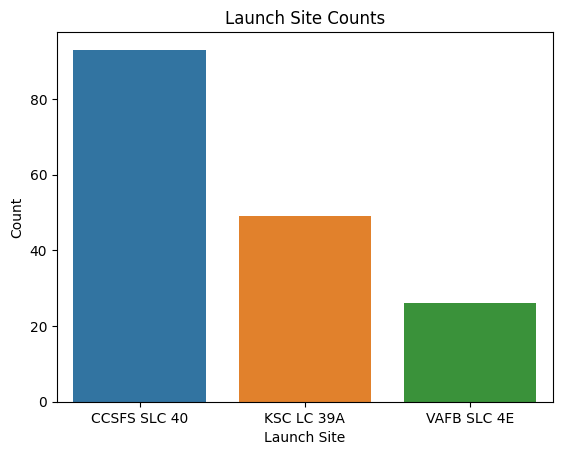

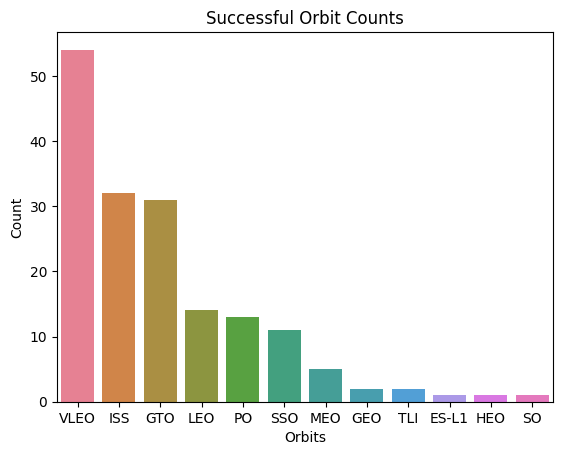

In [15]:
import matplotlib.pyplot as plt
launch_site_counts = data_falcon9['LaunchSite'].value_counts().reset_index()
launch_site_counts.columns = ['LaunchSite', 'Number of Launchings']

Orbit_Counts = data_falcon9['Orbit'].value_counts().reset_index()
Orbit_Counts.columns=['Orbit', 'Number of Successful orbits']

sb.barplot(x='LaunchSite', y='Number of Launchings',hue='LaunchSite', data=launch_site_counts)
plt.xlabel('Launch Site')
plt.ylabel('Count')
plt.title('Launch Site Counts')
plt.show()

sb.barplot(x='Orbit', y='Number of Successful orbits',hue='Orbit', data=Orbit_Counts)
plt.xlabel('Orbits')
plt.ylabel('Count')
plt.title('Successful Orbit Counts')
plt.show()


In [16]:
unique_items = data_falcon9['Outcome'].unique()
unique_items

array(['None None', 'False Ocean', 'True Ocean', 'False ASDS',
       'None ASDS', 'True RTLS', 'True ASDS', 'False RTLS'], dtype=object)

# Interigation of the data using SQL

In [17]:
!pip3 install ipython-sql



In [18]:
%load_ext sql


In [19]:
import csv, sqlite3

con = sqlite3.connect("my_data1.db")
cur = con.cursor()

In [20]:
%sql sqlite:///my_data1.db

In [21]:
import pandas as pd
df = pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/labs/module_2/data/Spacex.csv")
df.to_sql("SPACEXTBL", con, if_exists='replace', index=False,method="multi")


101

In [22]:
%sql create table SPACEXTABLE as select * from SPACEXTBL where Date is not null

 * sqlite:///my_data1.db
(sqlite3.OperationalError) table SPACEXTABLE already exists
[SQL: create table SPACEXTABLE as select * from SPACEXTBL where Date is not null]
(Background on this error at: https://sqlalche.me/e/20/e3q8)


In [38]:
 job1= '''
         select * FROM SPACEXTABLE
'''
table = pd.read_sql_query(job1, con)
table

,Date,Time (UTC),Booster_Version,Launch_Site,Payload,PAYLOAD_MASS__KG_,Orbit,Customer,Mission_Outcome,Landing_Outcome
0,2010-06-04,18:45:00,F9 v1.0 B0003,CCAFS LC-40,Dragon Spacecraft Qualification Unit,0,LEO,SpaceX,Success,Failure (parachute)
1,2010-12-08,15:43:00,F9 v1.0 B0004,CCAFS LC-40,"Dragon demo flight C1, two CubeSats, barrel of Brouere cheese",0,LEO (ISS),NASA (COTS) NRO,Success,Failure (parachute)
2,2012-05-22,7:44:00,F9 v1.0 B0005,CCAFS LC-40,Dragon demo flight C2,525,LEO (ISS),NASA (COTS),Success,No attempt
3,2012-10-08,0:35:00,F9 v1.0 B0006,CCAFS LC-40,SpaceX CRS-1,500,LEO (ISS),NASA (CRS),Success,No attempt
4,2013-03-01,15:10:00,F9 v1.0 B0007,CCAFS LC-40,SpaceX CRS-2,677,LEO (ISS),NASA (CRS),Success,No attempt
...,...,...,...,...,...,...,...,...,...,...
96,2020-11-05,23:24:23,F9 B5B1062.1,CCAFS SLC-40,"GPS III-04 , Crew-1",4311,MEO,USSF,Success,Success
97,2020-11-16,0:27:00,F9 B5B1061.1,KSC LC-39A,"Crew-1, Sentinel-6 Michael Freilich",12500,LEO (ISS),NASA (CCP),Success,Success
98,2020-11-21,17:17:08,F9 B5B1063.1,VAFB SLC-4E,"Sentinel-6 Michael Freilich, Starlink 15 v1.0",1192,LEO,NASA / NOAA / ESA / EUMETSAT,Success,Success
99,2020-11-25,2:13:00,F9 B5 B1049.7,CCAFS SLC-40,"Starlink 15 v1.0, SpaceX CRS-21",15600,LEO,SpaceX,Success,Success


### Unique Launch Sites

In [24]:
job2= '''
         select DISTINCT Launch_Site FROM SPACEXTABLE
'''
table = pd.read_sql_query(job2, con)
table

,Launch_Site
0,CCAFS LC-40
1,VAFB SLC-4E
2,KSC LC-39A
3,CCAFS SLC-40


### All launch sites with names starting with 'CCA'

In [25]:
job3= '''
         select * FROM SPACEXTABLE
         WHERE Launch_Site LIKE 'CCA%'
         LIMIt 5
'''
table = pd.read_sql_query(job3, con)
table

,Date,Time (UTC),Booster_Version,Launch_Site,Payload,PAYLOAD_MASS__KG_,Orbit,Customer,Mission_Outcome,Landing_Outcome
0,2010-06-04,18:45:00,F9 v1.0 B0003,CCAFS LC-40,Dragon Spacecraft Qualification Unit,0,LEO,SpaceX,Success,Failure (parachute)
1,2010-12-08,15:43:00,F9 v1.0 B0004,CCAFS LC-40,"Dragon demo flight C1, two CubeSats, barrel of Brouere cheese",0,LEO (ISS),NASA (COTS) NRO,Success,Failure (parachute)
2,2012-05-22,7:44:00,F9 v1.0 B0005,CCAFS LC-40,Dragon demo flight C2,525,LEO (ISS),NASA (COTS),Success,No attempt
3,2012-10-08,0:35:00,F9 v1.0 B0006,CCAFS LC-40,SpaceX CRS-1,500,LEO (ISS),NASA (CRS),Success,No attempt
4,2013-03-01,15:10:00,F9 v1.0 B0007,CCAFS LC-40,SpaceX CRS-2,677,LEO (ISS),NASA (CRS),Success,No attempt


### Total Payload Mass in KG

In [26]:
job4= '''
         select SUM(PAYLOAD_MASS__KG_) as TotalMass FROM SPACEXTABLE
         WHERE Customer LIKE 'NASA (CRS)'
          
'''
table = pd.read_sql_query(job4, con)
table

,TotalMass
0,45596


### AVG Payload Mass in KG

In [27]:
job5= '''
         select AVG(PAYLOAD_MASS__KG_) as AvgMass FROM SPACEXTABLE
         WHERE Booster_Version = 'F9 v1.1'
          
'''
table = pd.read_sql_query(job5, con)
table

,AvgMass
0,2928.4


### Successful & Un-Successful Missions

In [28]:
job6= '''
         select COUNT('Mission_Outcome') as [Successful Missions]  FROM SPACEXTABLE
         WHERE Mission_Outcome Like '%Success'
          
'''
table = pd.read_sql_query(job6, con)
table

job7= '''
         select COUNT('Mission_Outcome') as [Un-Successful Missions]  FROM SPACEXTABLE
         WHERE Mission_Outcome Like 'Failure%'
          
'''
table1 = pd.read_sql_query(job7, con)
table1

,Un-Successful Missions
0,1


In [29]:
job6= '''
         select COUNT('Mission_Outcome') as [Successful Missions]  FROM SPACEXTABLE
         WHERE Mission_Outcome Like '%Success'
          
'''
table = pd.read_sql_query(job6, con)
table

,Successful Missions
0,98


### Failed landings on Drone ship between 2015-01-01 and 2015-12-31

In [41]:
job8= '''
         select Mission_Outcome, Launch_Site, Booster_Version, Landing_Outcome FROM SPACEXTABLE
         WHERE Landing_Outcome Like 'Failure (Drone Ship)' AND DATE BETWEEN '2015-01-01' AND '2015-12-31'          
'''
table = pd.read_sql_query(job8, con)
table
          



,Mission_Outcome,Launch_Site,Booster_Version,Landing_Outcome
0,Success,CCAFS LC-40,F9 v1.1 B1012,Failure (drone ship)
1,Success,CCAFS LC-40,F9 v1.1 B1015,Failure (drone ship)


In [31]:
job6= '''
         select MIN(Date) as [First successful date] FROM SPACEXTABLE
         WHERE Landing_Outcome Like 'Success (ground pad)'  
          
'''
table = pd.read_sql_query(job6, con)
table


,First successful date
0,2015-12-22


In [32]:
job8= '''
         select Mission_Outcome, Booster_Version, Landing_Outcome FROM SPACEXTABLE
         WHERE Landing_Outcome Like 'Success (Drone Ship)' AND PAYLOAD_MASS__KG_ BETWEEN 4000 AND 6000        
'''
table = pd.read_sql_query(job8, con)
table

,Mission_Outcome,Booster_Version,Landing_Outcome
0,Success,F9 FT B1022,Success (drone ship)
1,Success,F9 FT B1026,Success (drone ship)
2,Success,F9 FT B1021.2,Success (drone ship)
3,Success,F9 FT B1031.2,Success (drone ship)


In [39]:
job9= '''
        SELECT Booster_version, PAYLOAD_MASS__KG_
        FROM SPACEXTABLE

        WHERE PAYLOAD_MASS__KG_ = (
                                    select max( PAYLOAD_MASS__KG_ ) 
                                    FROM SPACEXTABLE
                                    ) 
        '''
table = pd.read_sql_query(job9, con)
table

,Booster_Version,PAYLOAD_MASS__KG_
0,F9 B5 B1048.4,15600
1,F9 B5 B1049.4,15600
2,F9 B5 B1051.3,15600
3,F9 B5 B1056.4,15600
4,F9 B5 B1048.5,15600
5,F9 B5 B1051.4,15600
6,F9 B5 B1049.5,15600
7,F9 B5 B1060.2,15600
8,F9 B5 B1058.3,15600
9,F9 B5 B1051.6,15600


In [40]:
job9= '''
        SELECT Booster_version, MAX(PAYLOAD_MASS__KG_)
        FROM SPACEXTABLE

       
        '''
table = pd.read_sql_query(job9, con)
table

,Booster_Version,MAX(PAYLOAD_MASS__KG_)
0,F9 B5 B1048.4,15600


In [44]:
job10 = '''
        SELECT Landing_Outcome, COUNT(Landing_Outcome)
        FROM SPACEXTABLE
        WHERE DATE BETWEEN '2010-06-04' AND '2017-03-20'
        GROUP BY Landing_Outcome
        ORDER BY count(landing_Outcome) DESC
         
'''
table = pd.read_sql_query(job10,con)
table


,Landing_Outcome,COUNT(Landing_Outcome)
0,No attempt,10
1,Success (drone ship),5
2,Failure (drone ship),5
3,Success (ground pad),3
4,Controlled (ocean),3
5,Uncontrolled (ocean),2
6,Failure (parachute),2
7,Precluded (drone ship),1
